In [1]:
import pandas as pd

import numpy as np

import os

import sys


import librosa

import librosa.display

import seaborn as sns

import matplotlib.pyplot as plt



from sklearn.preprocessing import StandardScaler, OneHotEncoder

from sklearn.metrics import confusion_matrix, classification_report

from sklearn.model_selection import train_test_split



# to play the audio files

from IPython.display import Audio



import keras

from keras.callbacks import ReduceLROnPlateau

from keras.models import Sequential

from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization

from keras.utils import to_categorical

from keras.callbacks import ModelCheckpoint



import warnings

if not sys.warnoptions:

    warnings.simplefilter("ignore")

warnings.filterwarnings("ignore", category=DeprecationWarning)

In [2]:
# Manual np_utils functionalities

import numpy as np



def np_utils(y, num_classes=None):

    y = np.array(y, dtype='int')

    input_shape = y.shape

    if input_shape and input_shape[-1] == 1 and len(input_shape) > 1:

        input_shape = tuple(input_shape[:-1])

    y = y.ravel()

    if not num_classes:

        num_classes = np.max(y) + 1

    n = y.shape[0]

    categorical = np.zeros((n, num_classes))

    categorical[np.arange(n), y] = 1

    output_shape = input_shape + (num_classes,)

    categorical = np.reshape(categorical, output_shape)

    return categorical

In [ ]:
Crema = "/kaggle/input/cremad/AudioWAV/"

In [3]:
import os
import pandas as pd

data_directory = '/kaggle/input/berlin-database-of-emotional-speech-emodb/wav'
directory_list = os.listdir(data_directory)

file_emotion = []
file_path = []

# Emotion mapping based on provided information
emotion_mapping = {
    'W': 'anger',
    'L': 'boredom',
    'E': 'disgust',
    'A': 'anxiety/fear',
    'F': 'happiness',
    'T': 'sadness',
    'N': 'neutral'
}

for file in directory_list:
    # storing file paths
    file_path.append(os.path.join(data_directory, file))
    
    # extracting emotion code from the file name and mapping it to emotion
    emotion_code = file[5]  # extracting the character representing emotion
    emotion = emotion_mapping.get(emotion_code, 'Unknown')
    file_emotion.append(emotion)

# Creating DataFrame
emotion_df = pd.DataFrame(file_emotion, columns=['Emotion'])
path_df = pd.DataFrame(file_path, columns=['Path'])
emodb_df = pd.concat([path_df, emotion_df], axis=1)

# Displaying the first few rows
print(emodb_df.head())

# Optionally save to CSV
emodb_df.to_csv('emodb.csv', index=False)


                                                Path    Emotion
0  /kaggle/input/berlin-database-of-emotional-spe...  happiness
1  /kaggle/input/berlin-database-of-emotional-spe...  happiness
2  /kaggle/input/berlin-database-of-emotional-spe...      anger
3  /kaggle/input/berlin-database-of-emotional-spe...      anger
4  /kaggle/input/berlin-database-of-emotional-spe...      anger


In [6]:
audio_file = '/kaggle/input/berlin-database-of-emotional-speech-emodb/wav/03a01Fa.wav' # Replace with actual file paths

print("Sampling Rate : "+ str(librosa.get_samplerate(audio_file))+"Hz")

print("Duration : "+ str(librosa.get_duration(filename=audio_file))+"s")


signal, sampling_rate = librosa.load(audio_file, sr=44100, mono=False)

print("Shape of Initial Data : "+ str(signal.shape))

Sampling Rate : 16000Hz
Duration : 1.89825s
Shape of Initial Data : (83713,)


In [7]:
print(signal.shape)# Initially the signal is in stereo form (2 channels)

audio_mono = librosa.to_mono(signal)

print(audio_mono.shape) # Mono signal

(83713,)
(83713,)


Original Sampling Rate : 44100 Hz
(53709,)
(214834,)


# EDA

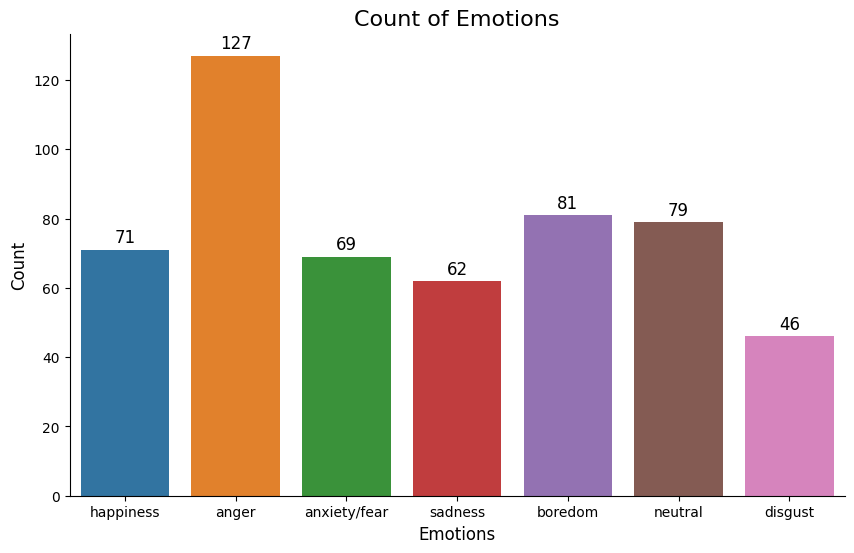

In [9]:
plt.figure(figsize=(10, 6))

plt.title('Count of Emotions', size=16)

count_plot = sns.countplot(data=emodb_df, x='Emotion')

plt.ylabel('Count', size=12)

plt.xlabel('Emotions', size=12)

sns.despine(top=True, right=True, left=False, bottom=False)



# Annotate the bars with the count values

for p in count_plot.patches:

    count = int(p.get_height())

    count_plot.annotate(f'{count}', (p.get_x() + p.get_width() / 2., p.get_height()),

                        ha='center', va='baseline', fontsize=12, color='black', xytext=(0, 5),

                        textcoords='offset points')



plt.show()

In [10]:
def create_waveplot(data, sr, e):

    plt.figure(figsize=(10, 3))

    plt.title('Waveplot for audio with {} emotion'.format(e), size=15)

    librosa.display.waveshow(data, sr=sr)

    plt.show()



def create_spectrogram(data, sr, e):

    # stft function converts the data into short term fourier transform

    X = librosa.stft(data)

    Xdb = librosa.amplitude_to_db(abs(X))

    plt.figure(figsize=(12, 3))

    plt.title('Spectrogram for audio with {} emotion'.format(e), size=15)

    librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')

    plt.colorbar()

    plt.show()

#  Audio Augmentation

In [13]:
def noise(data):

    noise_amp = 0.035 * np.random.uniform() * np.amax(data)

    data = data + noise_amp * np.random.normal(size=data.shape[0])

    return data



def stretch(data, rate=0.8):

    D = librosa.stft(data)

    # Stretch using phase vocoder

    stretched = librosa.phase_vocoder(D, rate=rate)

    # Inverse STFT to get the stretched audio signal

    stretched_audio = librosa.istft(stretched)

    return stretched_audio



def shift(data):

    shift_range = int(np.random.uniform(low=-5, high=5) * 1000)

    return np.roll(data, shift_range)



def pitch(data, sampling_rate, pitch_factor=0.7):

    data_stretched = stretch(data, rate=pitch_factor)

    return data_stretched



# Taking any example and checking for techniques

path = np.array(emodb_df.Path)[1]

data, sample_rate = librosa.load(path)

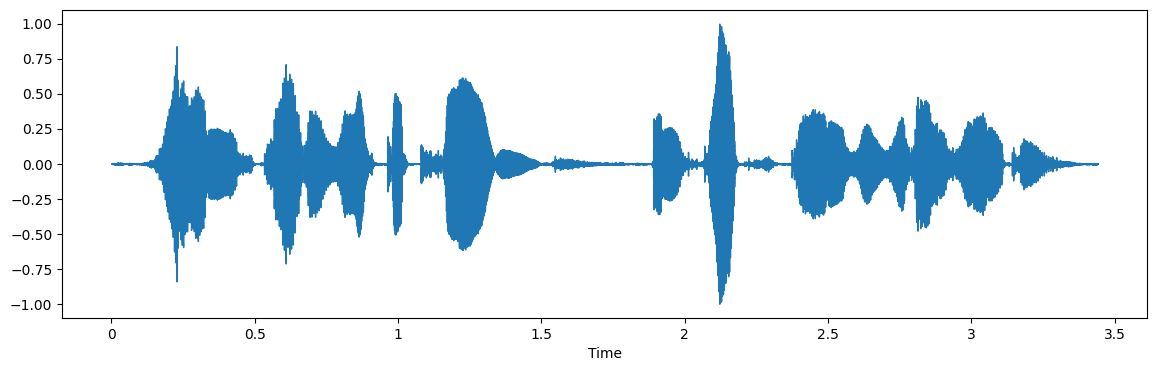

In [15]:
plt.figure(figsize=(14,4))

librosa.display.waveshow(y=data, sr=sample_rate)

Audio(path)

# Feature Extraction

In [16]:
def extract_features(data, sample_rate):

    # ZCR

    result = np.array([])

    zcr = np.mean(librosa.feature.zero_crossing_rate(y=data).T, axis=0)

    result = np.hstack((result, zcr))  # stacking horizontally



    # Chroma_stft

    stft = np.abs(librosa.stft(data))

    chroma_stft = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T, axis=0)

    result = np.hstack((result, chroma_stft))  # stacking horizontally



    # MFCC

    mfcc = np.mean(librosa.feature.mfcc(y=data, sr=sample_rate).T, axis=0)

    result = np.hstack((result, mfcc))  # stacking horizontally



    # Root Mean Square Value

    rms = np.mean(librosa.feature.rms(y=data).T, axis=0)

    result = np.hstack((result, rms))  # stacking horizontally



    # MelSpectogram

    mel = np.mean(librosa.feature.melspectrogram(y=data, sr=sample_rate).T, axis=0)

    result = np.hstack((result, mel))  # stacking horizontally



    return result



def get_features(path, emotion=None):

    # duration and offset are used to take care of the no audio in start and the ending of each audio files as seen above.

    data, sample_rate = librosa.load(path, duration=2.5, offset=0.6)



    # without augmentation

    res1 = extract_features(data, sample_rate)

    result = [(res1, emotion)]



    # data with noise

    noise_data = noise(data)

    res2 = extract_features(noise_data, sample_rate)

    result.append((res2, emotion))



    # data with stretching and pitching

    new_data = stretch(data)

    data_stretch_pitch = pitch(new_data, sample_rate)

    res3 = extract_features(data_stretch_pitch, sample_rate)

    result.append((res3, emotion))



    shifted_data = shift(data)

    res4 = extract_features(shifted_data, sample_rate)

    result.append((res4, emotion))



    return result

In [17]:
from joblib import Parallel, delayed

In [20]:
def process_file(path, emotion):

    features = get_features(path, emotion)

    return features



# Use joblib to parallelize the process

result = Parallel(n_jobs=-1)(delayed(process_file)(path, emotion) for path, emotion in zip(emodb_df.Path, emodb_df.Emotion))



# Flatten the results and separate X and Y

X, Y = zip(*[item for sublist in result for item in sublist])



# Convert to numpy arrays

X = np.array(X)

Y = np.array(Y)

In [23]:
len(X), len(Y), emodb_df.Path.shape

(2140, 2140, (535,))

In [24]:
Features = pd.DataFrame(X)

Features['labels'] = Y

Features.to_csv('features-emodb-bi-lstm.csv', index=False)

Features.head()

,0,1,2,3,4,5,6,7,8,9,...,153,154,155,156,157,158,159,160,161,labels
0,0.111901,0.522873,0.640779,0.680774,0.638936,0.627278,0.566352,0.541697,0.558623,0.587975,...,2.585491e-09,2.403906e-09,2.275349e-09,2.180046e-09,2.109122e-09,2.058343e-09,2.021503e-09,1.997684e-09,1.982962e-09,happiness
1,0.221379,0.636897,0.715826,0.702138,0.733668,0.654655,0.571616,0.548854,0.605559,0.643426,...,2.070262e-02,2.136503e-02,2.098761e-02,1.977026e-02,2.045954e-02,2.161945e-02,2.123101e-02,2.242348e-02,1.995565e-02,happiness
2,0.101473,0.485186,0.526355,0.650654,0.584283,0.610925,0.521776,0.541441,0.550313,0.557617,...,2.473224e-09,2.349601e-09,2.263219e-09,2.188915e-09,2.158080e-09,2.100482e-09,2.053466e-09,2.041833e-09,2.030065e-09,happiness
3,0.110652,0.560743,0.674847,0.633027,0.636801,0.580772,0.555057,0.529833,0.575287,0.577488,...,5.365169e-08,3.957456e-08,2.963037e-08,2.234236e-08,1.693970e-08,1.297914e-08,1.005058e-08,8.085832e-09,6.909358e-09,happiness
4,0.084663,0.422190,0.431405,0.442674,0.439183,0.461294,0.441147,0.499073,0.616181,0.651516,...,1.644588e-06,1.526782e-06,1.443090e-06,1.380714e-06,1.334285e-06,1.300964e-06,1.276776e-06,1.261152e-06,1.251502e-06,happiness


In [25]:
import numpy as np

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler, OneHotEncoder

from collections import Counter

from sklearn.decomposition import PCA

import pandas as pd



# Assuming X and Y are your features and labels respectively

# Check the unique classes and their counts in Y

unique_classes = np.unique(Y)

print("Unique classes in Y:", unique_classes)

print("Number of unique classes:", len(unique_classes))



# Check the distribution of classes

class_distribution = Counter(Y)

print("Class distribution:", class_distribution)



# Proceed with data splitting

x_train, x_test, y_train, y_test = train_test_split(X, Y, random_state=0, shuffle=True)



# Verify the unique classes in the train and test splits

print("Unique classes in y_train:", np.unique(y_train))

print("Unique classes in y_test:", np.unique(y_test))



# Scaling data

scaler = StandardScaler()

x_train = scaler.fit_transform(x_train)

x_test = scaler.transform(x_test)



# Making data compatible with model

x_train = np.expand_dims(x_train, axis=2)

x_test = np.expand_dims(x_test, axis=2)



# One-hot encoding the target data

encoder = OneHotEncoder()

y_train = encoder.fit_transform(y_train.reshape(-1, 1)).toarray()

y_test = encoder.transform(y_test.reshape(-1, 1)).toarray()



print("Shape of y_train after one-hot encoding:", y_train.shape)

print("Shape of y_test after one-hot encoding:", y_test.shape)



# Check the number of classes

num_classes = y_train.shape[1]

print("Number of classes:", num_classes)



# Save features to a CSV file

Features = pd.DataFrame(X)

Features['labels'] = Y

Features.to_csv('features.csv', index=False)

Features.head()



# Apply PCA

scaler = StandardScaler()

X_scaled = scaler.fit_transform(X)

pca = PCA(n_components=0.95)  # Choose the number of components to explain 95% of the variance

X_pca = pca.fit_transform(X_scaled)



# Check the number of components after PCA

print("Number of components after PCA:", X_pca.shape[1])



# Split the data into train and test sets

x_train_pca, x_test_pca, y_train_pca, y_test_pca = train_test_split(X_pca, Y, test_size=0.2, random_state=128)

Unique classes in Y: ['anger' 'anxiety/fear' 'boredom' 'disgust' 'happiness' 'neutral'
 'sadness']
Number of unique classes: 7
Class distribution: Counter({'anger': 508, 'boredom': 324, 'neutral': 316, 'happiness': 284, 'anxiety/fear': 276, 'sadness': 248, 'disgust': 184})
Unique classes in y_train: ['anger' 'anxiety/fear' 'boredom' 'disgust' 'happiness' 'neutral'
 'sadness']
Unique classes in y_test: ['anger' 'anxiety/fear' 'boredom' 'disgust' 'happiness' 'neutral'
 'sadness']
Shape of y_train after one-hot encoding: (1605, 7)
Shape of y_test after one-hot encoding: (535, 7)
Number of classes: 7
Number of components after PCA: 68


In [26]:
print("Shape of y_train_pca:", y_train_pca.shape)

Shape of y_train_pca: (1712,)


In [27]:
from sklearn.preprocessing import LabelEncoder

import tensorflow as tf



# Create the LabelEncoder instance

label_encoder = LabelEncoder()



# Fit and transform the training labels

y_train_encoded = label_encoder.fit_transform(y_train_pca)



# Transform the test labels

y_test_encoded = label_encoder.transform(y_test_pca)



# Get the number of classes

num_classes = len(label_encoder.classes_)



# Convert labels to one-hot encoding

y_train_one_hot = tf.keras.utils.to_categorical(y_train_encoded, num_classes)

y_test_one_hot = tf.keras.utils.to_categorical(y_test_encoded, num_classes)

In [28]:
from imblearn.over_sampling import SMOTE



# Apply SMOTE to balance the training data

smote = SMOTE(random_state=42)

x_train_resampled, y_train_resampled = smote.fit_resample(x_train_pca, y_train_encoded)

y_train_resampled_one_hot = tf.keras.utils.to_categorical(y_train_resampled, num_classes)



# Reshape data for LSTM input

x_train_resampled_reshaped = np.reshape(x_train_resampled, (x_train_resampled.shape[0], 1, x_train_resampled.shape[1]))

x_test_pca_reshaped = np.reshape(x_test_pca, (x_test_pca.shape[0], 1, x_test_pca.shape[1]))


In [39]:
#from tensorflow.keras.callbacks import EarlyStopping

# Model 1 <-> Bi-LSTM

In [29]:
import tensorflow as tf

from sklearn.preprocessing import LabelEncoder



from tensorflow.keras.layers import Bidirectional, LSTM, Dropout, Dense

# Create the model

model1 = Sequential()

model1.add(Bidirectional(LSTM(128, return_sequences=True), input_shape=(1, x_train_pca.shape[1])))

model1.add(Dropout(0.2))

model1.add(Bidirectional(LSTM(64)))

model1.add(Dropout(0.2))

model1.add(Dense(128, activation='relu'))

model1.add(Dense(num_classes, activation='softmax'))



# Compile the model

model1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])



# Early stopping to prevent overfitting



# Train the model

history1 = model1.fit(x_train_resampled_reshaped, y_train_resampled_one_hot,

                    validation_data=(x_test_pca_reshaped, y_test_one_hot),

                    epochs=200, batch_size=32)



# Evaluate the model

loss, accuracy = model1.evaluate(x_test_pca_reshaped, y_test_one_hot)

print("Test Accuracy:", accuracy)



# Generate predictions

y_pred_prob = model1.predict(x_test_pca_reshaped)

y_pred = np.argmax(y_pred_prob, axis=1)



# Generate classification report

print(classification_report(y_test_encoded, y_pred, target_names=label_encoder.classes_))



# Print model summary

print(model1.summary())

Epoch 1/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - accuracy: 0.4075 - loss: 1.6690 - val_accuracy: 0.6519 - val_loss: 0.8533
Epoch 2/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.7584 - loss: 0.6260 - val_accuracy: 0.8131 - val_loss: 0.4637
Epoch 3/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.8943 - loss: 0.3230 - val_accuracy: 0.8645 - val_loss: 0.3653
Epoch 4/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9359 - loss: 0.1965 - val_accuracy: 0.8855 - val_loss: 0.3163
Epoch 5/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9602 - loss: 0.1231 - val_accuracy: 0.9089 - val_loss: 0.2672
Epoch 6/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9701 - loss: 0.0858 - val_accuracy: 0.9136 - val_loss: 0.2871
Epoch 7/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9846 - loss: 0.0548 - val_accuracy: 0.9182 - val_loss: 0.2525
Epoch 8/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9843 - loss: 0.0511 - val_accuracy: 0.

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional (Bidirectional)   │ (None, 1, 256)         │       201,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1, 256)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 128)            │       164,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 7)              │           903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,150,487 (4.39 MB)

 Trainable params: 383,495 (1.46 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 766,992 (2.93 MB)

None


In [36]:
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score

y_pred = model1.predict(x_test_pca_reshaped)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test_one_hot, axis=1)

# Calculate precision, recall, and F1 score
precision = precision_score(y_true_classes, y_pred_classes, average='weighted')
recall = recall_score(y_true_classes, y_pred_classes, average='weighted')
f1 = f1_score(y_true_classes, y_pred_classes, average='weighted')

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

# Detailed classification report
print(classification_report(y_true_classes, y_pred_classes))

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Precision: 0.9472614335462811
Recall: 0.9462616822429907
F1 Score: 0.9460644274195146
              precision    recall  f1-score   support

           0       0.97      0.99      0.98        97
           1       0.98      0.88      0.93        64
           2       0.96      0.93      0.94        70
           3       0.97      1.00      0.98        30
           4       0.93      0.95      0.94        57
           5       0.90      0.97      0.93        59
           6       0.90      0.92      0.91        51

    accuracy                           0.95       428
   macro avg       0.95      0.95      0.95       428
weighted avg       0.95      0.95      0.95       428



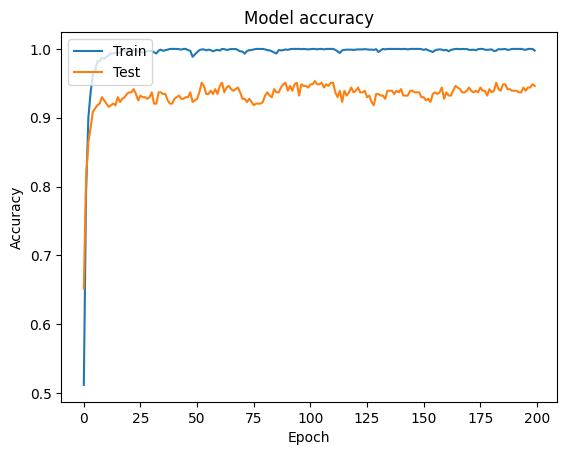

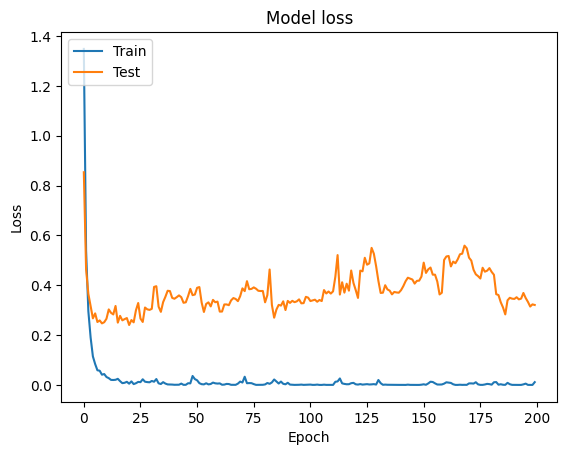

In [30]:
import matplotlib.pyplot as plt



# Plot training & validation accuracy values

plt.plot(history1.history['accuracy'])

plt.plot(history1.history['val_accuracy'])

plt.title('Model accuracy')

plt.xlabel('Epoch')

plt.ylabel('Accuracy')

plt.legend(['Train', 'Test'], loc='upper left')

plt.show()



# Plot training & validation loss values

plt.plot(history1.history['loss'])

plt.plot(history1.history['val_loss'])

plt.title('Model loss')

plt.xlabel('Epoch')

plt.ylabel('Loss')

plt.legend(['Train', 'Test'], loc='upper left')

plt.show()

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


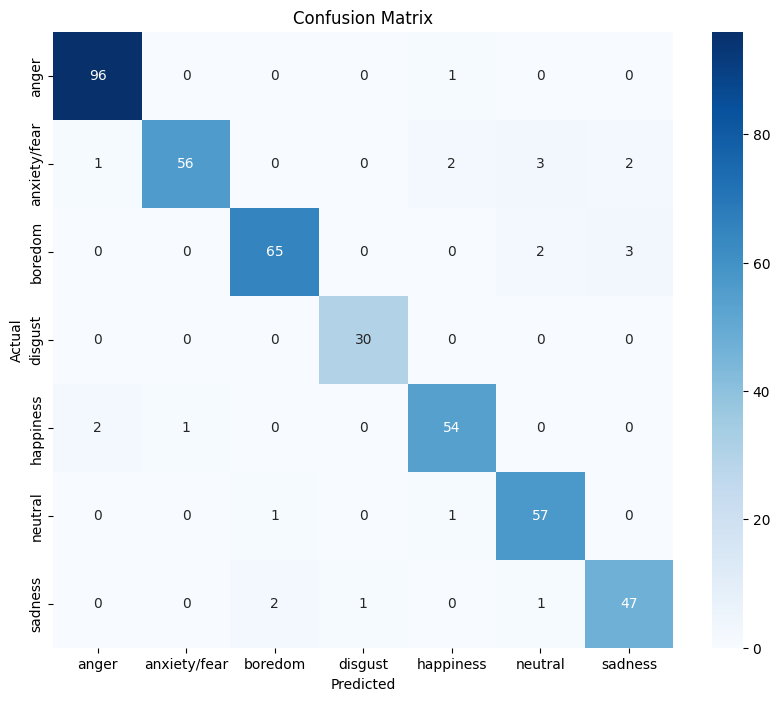

In [31]:
from sklearn.metrics import confusion_matrix

import seaborn as sns



# Predict probabilities for each class

y_pred_probs = model1.predict(x_test_pca_reshaped)



# Convert probabilities to class labels

y_pred = np.argmax(y_pred_probs, axis=1)



# Calculate confusion matrix

cm = confusion_matrix(np.argmax(y_test_one_hot, axis=1), y_pred)



# Plot confusion matrix

plt.figure(figsize=(10, 8))

sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)

plt.xlabel('Predicted')

plt.ylabel('Actual')

plt.title('Confusion Matrix')

plt.show()

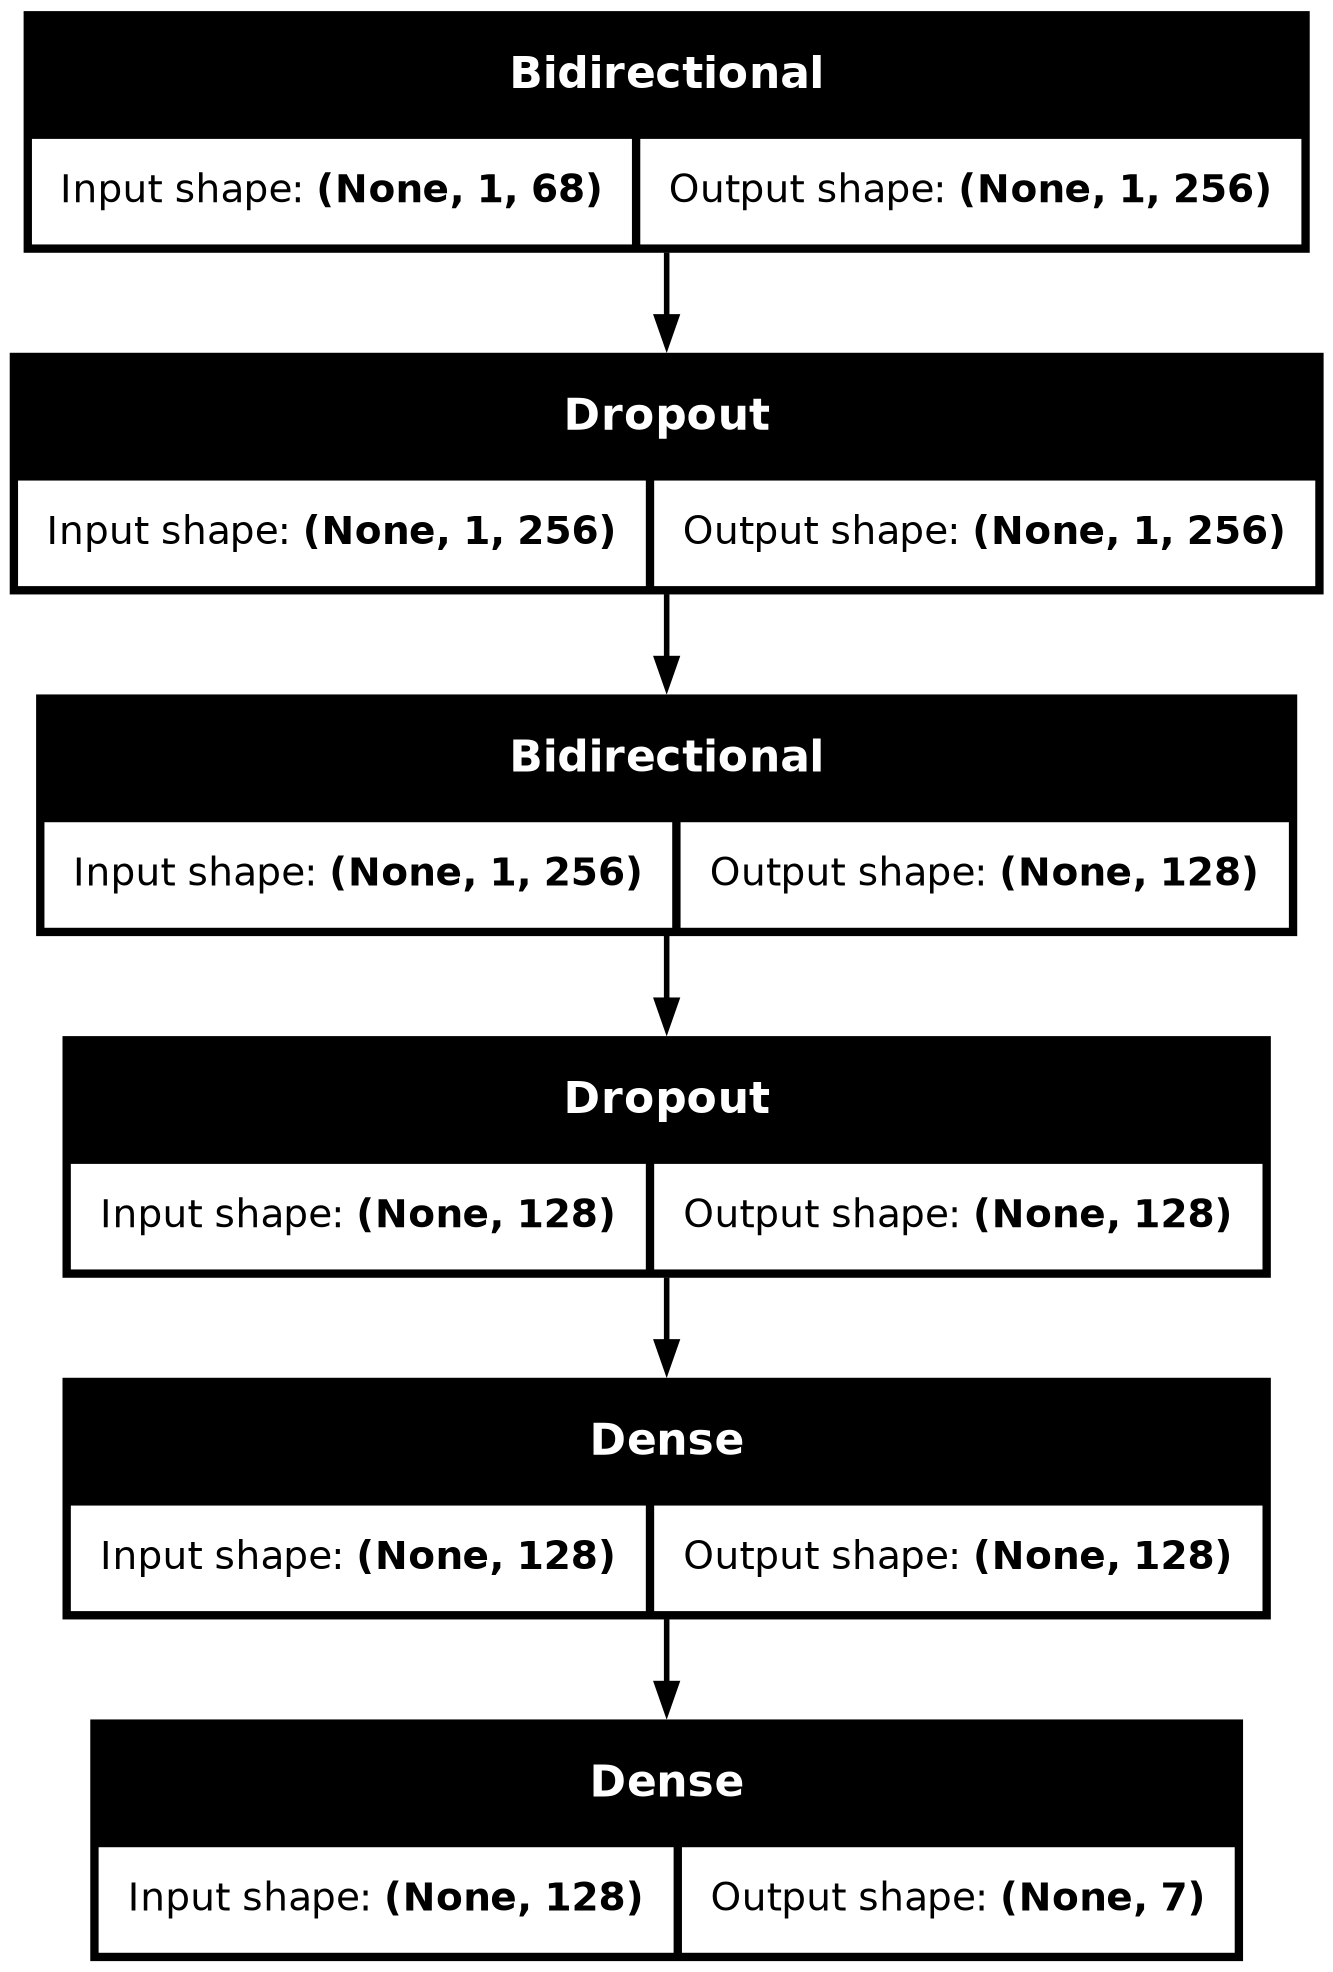

In [32]:
from tensorflow.keras.utils import plot_model



# Visualize the model architecture

plot_model(model1, to_file='model_1_architecture.png', show_shapes=True)